In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
quote = Quote(screen_funds('Industries'), 50, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

from 2019-05-20 to 2019-07-05 - 62


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0.2]
print(len(stats))
stats

46


,len,mean,std,shrp,drawdown
Symbols,,,,,
GDX,28,3.907228,4.502373,0.859002,6.075660
IHI,28,1.711112,2.011355,0.830997,2.045544
GDXJ,28,3.768778,4.967176,0.750748,6.657301
GUNR,28,1.131073,1.537185,0.709993,2.939322
GNR,28,1.235267,1.864290,0.641308,4.013521
FXH,28,1.301813,2.011808,0.627361,2.828641
BOTZ,28,1.611608,2.579644,0.609358,4.540822
XLB,28,1.691642,2.715633,0.608315,3.564901
VAW,28,1.618334,2.628990,0.600478,4.240808


evicted XLP 0.8450712097145918
evicted VCR 0.8420199133578771
evicted XAR 0.7429849691159542
evicted GUNR 0.6578656884050188
evicted XLF 0.8985034041702438
evicted XLC 0.7573406010625628
evicted RYT 0.8822688003658355
evicted XBI 0.7400520124774111
evicted XLB 0.7162071658153686
evicted SOXX 0.7039223980511218
retry backlogs ['IGM', 'FHLC', 'GNR', 'IYF', 'VAW', 'VHT', 'FNCL', 'QTEC', 'VFH', 'VGT', 'XT', 'FXL', 'FTEC', 'VIS', 'FBT', 'FXH', 'XLY', 'IYH', 'XLI', 'IXN', 'TDIV', 'IYW', 'IGF', 'FDN', 'XLV', 'IXJ', 'IGV', 'XLK', 'IYG', 'ITA', 'IBB', 'BOTZ', 'GDXJ'] at 0.905 - 1.198
evicted IGF 0.8937058608638231
evicted ITA 0.6819625928590771
evicted IGV 0.8941860258912396
evicted IBB 0.7833166574448676
evicted FNCL 0.8316316803351597
evicted GNR 0.7597438898764608
evicted QTEC 0.8568979420472156
evicted VAW 0.7112561846568214
retry backlogs ['IYH', 'VHT', 'XLK', 'XLI', 'VFH', 'TDIV', 'IYF', 'FXL', 'VGT', 'FHLC', 'VIS', 'IYW', 'IYG', 'XLV', 'FTEC', 'FXH', 'IXJ', 'XT', 'FBT', 'IXN', 'XLY', 'FD

,count,mean,std,min,25%,50%,75%,max,shrp,drawdown
Portfolio,28.0,2.696223,2.277990,-2.355798,1.717171,2.311472,4.354197,6.064996,1.166177,2.355798
GDX,28.0,3.907228,4.502373,-6.075660,0.441269,3.233056,7.855793,11.551582,0.859002,6.075660
IHI,28.0,1.711112,2.011355,-1.336111,0.141899,1.850479,2.955849,6.530127,0.830997,2.045544
ARKK,28.0,2.060506,3.861082,-5.421415,-0.563300,2.140411,5.060485,8.669655,0.523383,8.564925


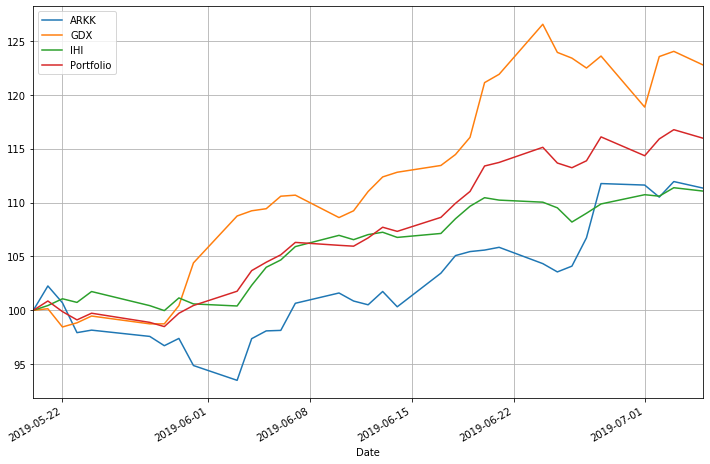

In [4]:
quote.setup_mask(stats.index)
ratio, shrp = quote.optimize_portfolio(.1)
print(ratio, shrp)
quote.setup_mask(ratio)
quote.graph(ratio)